In [9]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
crabdata = pd.read_csv("C:/Users/User/Documents/UNI/3rd year/semester 2/ML/Project 1/CrabAgePrediction.csv")
crabdata.head()
crabdata.info()
#remove height=0
crabdata = crabdata[crabdata['Height'] > 0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3893 non-null   object 
 1   Length          3893 non-null   float64
 2   Diameter        3893 non-null   float64
 3   Height          3893 non-null   float64
 4   Weight          3893 non-null   float64
 5   Shucked Weight  3893 non-null   float64
 6   Viscera Weight  3893 non-null   float64
 7   Shell Weight    3893 non-null   float64
 8   Age             3893 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 273.9+ KB


In [10]:
# Factorize the 'Sex' column
crabdata['Sex'] = pd.factorize(crabdata['Sex'])[0]

# Change the numerical encoding to specific labels
sex_labels = {0: 'Female', 1: 'Male', 2: 'Indeterminate'}  
crabdata['Sex'] = crabdata['Sex'].map(sex_labels)

# Show the first few rows of the DataFrame to verify the changes
print(crabdata.head())
crabdata.info()

             Sex  Length  Diameter  Height     Weight  Shucked Weight  \
0         Female  1.4375    1.1750  0.4125  24.635715       12.332033   
1           Male  0.8875    0.6500  0.2125   5.400580        2.296310   
2  Indeterminate  1.0375    0.7750  0.2500   7.952035        3.231843   
3         Female  1.1750    0.8875  0.2500  13.480187        4.748541   
4  Indeterminate  0.8875    0.6625  0.2125   6.903103        3.458639   

   Viscera Weight  Shell Weight  Age  
0        5.584852      6.747181    9  
1        1.374951      1.559222    6  
2        1.601747      2.764076    6  
3        2.282135      5.244657   10  
4        1.488349      1.700970    6  
<class 'pandas.core.frame.DataFrame'>
Index: 3891 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3891 non-null   object 
 1   Length          3891 non-null   float64
 2   Diameter        3891 non-null   float64
 

In [11]:
#data on different scales. so we standardize
from sklearn.preprocessing import StandardScaler
#split data to features and label by making a copy of each
X=crabdata[["Sex","Length","Height","Weight","Diameter","Shucked Weight", "Viscera Weight", "Shell Weight"]].copy()
X['Shucked_Weight_Ratio'] = X['Shucked Weight'] / X['Weight']
X['Shell_Weight_Ratio'] = X['Shell Weight'] / X['Weight']
X['Viscera_Weight_Ratio'] = X['Viscera Weight'] / X['Weight']

X.drop(columns=['Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight'], inplace=True)
Y=crabdata["Age"].copy()

In [12]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_cols = ["Sex"]
numerical_cols_to_scale = ["Length", "Diameter", "Height"]
numerical_cols_no_scale = ["Shucked_Weight_Ratio", "Viscera_Weight_Ratio", "Shell_Weight_Ratio"]

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num_scale', StandardScaler(), numerical_cols_to_scale),
        ('num_no_scale', 'passthrough', numerical_cols_no_scale),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Define the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_processed = pipeline.fit_transform(X)
print(X_processed)

[[ 0.41953843  0.62039253  0.60126404 ...  1.          0.
   0.        ]
 [-1.41179319 -1.49529346 -1.3091317  ...  0.          0.
   1.        ]
 [-0.91233911 -0.9915587  -0.9509325  ...  0.          1.
   0.        ]
 ...
 [-2.28583783 -2.25089561 -1.78673064 ...  0.          1.
   0.        ]
 [-0.82909676 -0.9915587  -0.83153277 ...  0.          1.
   0.        ]
 [-1.74476257 -1.64641389 -1.3091317  ...  0.          1.
   0.        ]]


In [13]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets 
X_train_scaled, X_test_scaled, Y_train, Y_test = train_test_split(X_processed, Y, 
                                                    train_size=0.8, 
                                                    random_state=123)

# Make log transformation
Y_train_log=np.log1p(Y_train)
Y_test_transformed = np.log1p(Y_test)

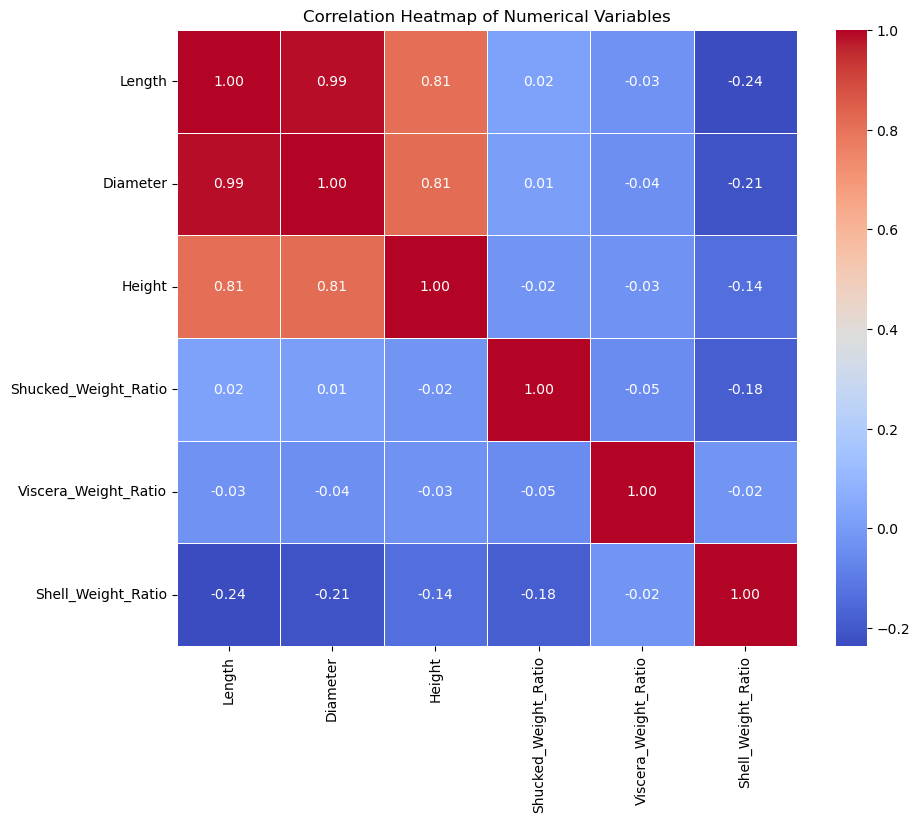

In [14]:
#CHECKING CORRELATION
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert X_train_scaled_cleaned to a DataFrame
X_train_df = pd.DataFrame(X_train_scaled, columns=['Length', 'Diameter', 'Height', 'Shucked_Weight_Ratio', 'Viscera_Weight_Ratio', 'Shell_Weight_Ratio', 'Sex_F', 'Sex_I', 'Sex_M'])

# Select only the numerical variables from the DataFrame
numerical_variables = X_train_df[['Length', 'Diameter', 'Height', 'Shucked_Weight_Ratio', 'Viscera_Weight_Ratio', 'Shell_Weight_Ratio']]

# Calculate the correlation matrix
correlation_matrix = numerical_variables.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Variables")
plt.show()

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a function to calculate VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Calculate VIF values for numerical variables
vif_numerical = calculate_vif(numerical_variables)

# Print the VIF values
print(vif_numerical)

                Feature        VIF
0                Length  37.375487
1              Diameter  37.992535
2                Height   2.980756
3  Shucked_Weight_Ratio  11.544981
4  Viscera_Weight_Ratio  24.694894
5    Shell_Weight_Ratio  22.934572


In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score


param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5]
}
rf_model_tuned = RandomForestRegressor()
grid_search_rf = GridSearchCV(rf_model_tuned, param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train_scaled, Y_train_log)

# Access the best parameters and best score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print("Best parameters for RandomForest:", best_params_rf)
print("Best score for RandomForest:", best_score_rf)

Best parameters for RandomForest: {'max_depth': 5, 'n_estimators': 300}
Best score for RandomForest: -0.02953614897418435


In [17]:
rf_model_best = RandomForestRegressor(**best_params_rf)
rf_model_best.fit(X_train_scaled, Y_train_log)
# Predictions on the training set
rf_train_predictions = rf_model_best.predict(X_train_scaled)
# Training MSE
rf_train_mse = mean_squared_error(Y_train_log, rf_train_predictions)
# Predictions on the test set
rf_test_predictions = rf_model_best.predict(X_test_scaled)
# Test MSE
rf_test_mse = mean_squared_error(Y_test_transformed, rf_test_predictions)
# RMSE for training predictions
rf_train_rmse = mean_squared_error(Y_train_log, rf_train_predictions, squared=False)
# RMSE for test predictions
rf_test_rmse = mean_squared_error(Y_test_transformed, rf_test_predictions, squared=False)
# MAE for training predictions
rf_train_mae = mean_absolute_error(Y_train_log, rf_train_predictions)
# MAE for test predictions
rf_test_mae = mean_absolute_error(Y_test_transformed, rf_test_predictions)
# R^2 for training predictions
rf_train_r2 = r2_score(Y_train_log, rf_train_predictions)
# R^2 for test predictions
rf_test_r2 = r2_score(Y_test_transformed, rf_test_predictions)
# Difference between train and test MSE
rf_mse_difference = rf_train_mse - rf_test_mse
# Calculate the difference between train and test MSE
rf_mse_difference= rf_train_mse - rf_test_mse
print("Random Forest Train MSE:", rf_train_mse)
print("Random Forest Test MSE:", rf_test_mse)
print("Random Forest Regression Train RMSE:", rf_train_rmse)
print("Random Forest Regression Test RMSE:", rf_test_rmse)
print("Random Forest Regression Train MAE:", rf_train_mae)
print("Random Forest Regression Test MAE:", rf_test_mae)
print("Random Forest Regression Train R^2:", rf_train_r2)
print("Random Forest Regression Test R^2:", rf_test_r2)
print("Random Forest Train-Test MSE Difference:", rf_mse_difference)

Random Forest Train MSE: 0.025574273268549774
Random Forest Test MSE: 0.02747155542375918
Random Forest Regression Train RMSE: 0.15991958375555437
Random Forest Regression Test RMSE: 0.1657454537046467
Random Forest Regression Train MAE: 0.12329842388768307
Random Forest Regression Test MAE: 0.12560319597325054
Random Forest Regression Train R^2: 0.689010697741555
Random Forest Regression Test R^2: 0.6553269685367424
Random Forest Train-Test MSE Difference: -0.0018972821552094045


In [18]:
#XGBOOST(without tuning)
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

# Create an instance of XGBRegressor with default parameters
xgb_model_default = XGBRegressor()

# Fit the model
xgb_model_default.fit(X_train_scaled, Y_train_log)

# Print the score (negative mean squared error)
score_default = xgb_model_default.score(X_train_scaled, Y_train_log)
print("Score for XGBoost (Default):", score_default)

Score for XGBoost (Default): 0.9588545069048537


In [19]:
# Predictions on the training set
xgb_train_predictions = xgb_model_default.predict(X_train_scaled)
# Calculate training MSE
xgb_train_mse = mean_squared_error(Y_train_log, xgb_train_predictions)
# Predictions on the test set
xgb_test_predictions = xgb_model_default.predict(X_test_scaled)
# Test MSE
xgb_test_mse = mean_squared_error(Y_test_transformed, xgb_test_predictions)
# RMSE for training predictions
xgb_train_rmse = mean_squared_error(Y_train_log, xgb_train_predictions, squared=False)
# RMSE for test predictions
xgb_test_rmse = mean_squared_error(Y_test_transformed, xgb_test_predictions, squared=False)
# MAE for training predictions
xgb_train_mae = mean_absolute_error(Y_train_log, xgb_train_predictions)
# MAE for test predictions
xgb_test_mae = mean_absolute_error(Y_test_transformed, xgb_test_predictions)
# R^2 for training predictions
xgb_train_r2 = r2_score(Y_train_log, xgb_train_predictions)
# R^2 for test predictions
xgb_test_r2 = r2_score(Y_test_transformed, xgb_test_predictions)
# Difference between train and test MSE
xgb_mse_difference = xgb_train_mse - xgb_test_mse
# Print the results
print("XGBoost Training MSE:", xgb_train_mse)
print("XGBoost Test MSE:", xgb_test_mse)
print("XGBoost Regression Train RMSE:", xgb_train_rmse)
print("XGBoost Regression Test RMSE:", xgb_test_rmse)
print("XGBoost Regression Train MAE:", xgb_train_mae)
print("XGBoost Regression Test MAE:", xgb_test_mae)
print("XGBoost Regression Train R^2:", xgb_train_r2)
print("XGBoost Regression Test R^2:", xgb_test_r2)
print("XGBoost Train-Test MSE Difference:", xgb_mse_difference)

XGBoost Training MSE: 0.003383608621077332
XGBoost Test MSE: 0.03266988367825875
XGBoost Regression Train RMSE: 0.05816879422058989
XGBoost Regression Test RMSE: 0.18074812219843048
XGBoost Regression Train MAE: 0.04270522078254261
XGBoost Regression Test MAE: 0.13973488616391833
XGBoost Regression Train R^2: 0.9588545069048537
XGBoost Regression Test R^2: 0.5901059233362993
XGBoost Train-Test MSE Difference: -0.02928627505718142


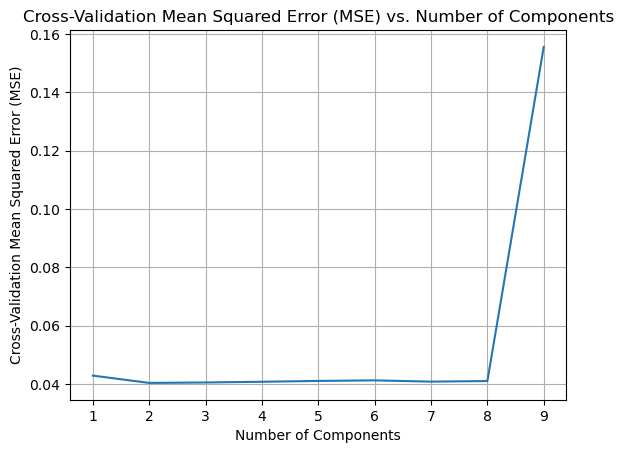

In [20]:
# PLS
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Define PLS Regression with varying number of components
pls_model_cv = PLSRegression()

components_range = range(1, 10)
cv_mse_scores = []  # Store MSE scores

for n_components in components_range:
    pls_model_cv.n_components = n_components
    # Perform cross-validation with MSE scoring
    scores = -1 * cross_val_score(pls_model_cv, X_train_scaled, Y_train_log, cv=5, scoring='neg_mean_squared_error')
    cv_mse_scores.append(scores.mean())

# Plot the cross-validation MSE scores
plt.plot(components_range, cv_mse_scores)
plt.xlabel('Number of Components')
plt.ylabel('Cross-Validation Mean Squared Error (MSE)')
plt.title('Cross-Validation Mean Squared Error (MSE) vs. Number of Components')
plt.grid(True)
plt.show()


In [15]:
# Instantiate PLS Regression(chose 2 components from above graph)
pls_model = PLSRegression(n_components=2) 

# Fit PLS Regression to the cleaned training data
pls_model.fit(X_train_scaled, Y_train_log)

# Predict on the cleaned training data
pls_train_predictions = pls_model.predict(X_train_scaled)

# Predict on the cleaned test data
pls_test_predictions = pls_model.predict(X_test_scaled)

# MSE for training predictions
pls_train_mse = mean_squared_error(Y_train_log, pls_train_predictions)

# MSE for test predictions
pls_test_mse = mean_squared_error(Y_test_transformed, pls_test_predictions)

# RMSE for training predictions
pls_train_rmse = mean_squared_error(Y_train_log, pls_train_predictions,squared=False)

# RMSE for test predictions
pls_test_rmse = mean_squared_error(Y_test_transformed, pls_test_predictions,squared=False)

# MAE for training predictions
pls_train_mae = mean_absolute_error(Y_train_log, pls_train_predictions)

# MAE for test predictions
pls_test_mae = mean_absolute_error(Y_test_transformed, pls_test_predictions)

# R^2 for training predictions
pls_train_r2 = r2_score(Y_train_log, pls_train_predictions)

# R^2 for test predictions
pls_test_r2 = r2_score(Y_test_transformed, pls_test_predictions)

# Difference between training and test MSE
pls_mse_difference = pls_train_mse - pls_test_mse

print("PLS Regression Train MSE:", pls_train_mse)
print("PLS Regression Test MSE:", pls_test_mse)
print("PLS Regression Train RMSE:", pls_train_rmse)
print("PLS Regression Test RMSE:", pls_test_rmse)
print("PLS Regression Train MAE:", pls_train_mae)
print("PLS Regression Test MAE:", pls_test_mae)
print("PLS Regression Train R^2:", pls_train_r2)
print("PLS Regression Test R^2:", pls_test_r2)
print("PLS Regression Train-Test MSE Difference:", pls_mse_difference)


PLS Regression Train MSE: 0.03821883700212687
PLS Regression Test MSE: 0.03326601769034094
PLS Regression Train RMSE: 0.19549638616129678
PLS Regression Test RMSE: 0.18238974118721957
PLS Regression Train MAE: 0.14610698946807896
PLS Regression Test MAE: 0.13932739772466055
PLS Regression Train R^2: 0.5352497673106053
PLS Regression Test R^2: 0.5826265027525993
PLS Regression Train-Test MSE Difference: 0.004952819311785928


In [8]:
import matplotlib.pyplot as plt

# Get the loadings for each component
pls_loadings = pls_model.x_loadings_

# Get the names of the numerical features
numerical_features = X_train.columns

# Plot loadings for the first component
plt.figure(figsize=(12, 6))
plt.bar(numerical_features, pls_loadings[:, 0], color='b', alpha=0.7)
plt.xlabel('Numerical Features')
plt.ylabel('Loadings for Component 1')
plt.title('Loadings Plot for PLS Regression (Component 1)')
plt.xticks(rotation=90)
plt.show()

# Plot loadings for the second component
plt.figure(figsize=(12, 6))
plt.bar(numerical_features, pls_loadings[:, 1], color='r', alpha=0.7)
plt.xlabel('Numerical Features')
plt.ylabel('Loadings for Component 2')
plt.title('Loadings Plot for PLS Regression (Component 2)')
plt.xticks(rotation=90)
plt.show()

# Plot loadings with response variable "Age"
plt.figure(figsize=(12, 6))
plt.bar(numerical_features, pls_loadings[:, 0], color='b', alpha=0.5, label='Component 1')
plt.bar(numerical_features, pls_loadings[:, 1], color='r', alpha=0.5, label='Component 2')
plt.xlabel('Numerical Features')
plt.ylabel('Loadings')
plt.title('Loadings Plot for PLS Regression')
plt.xticks(rotation=90)
plt.legend()
plt.show()


NameError: name 'pls_model' is not defined

In [16]:
#RIDGE REGRESSION
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score


param_grid_ridge = {
    'alpha': [0.1, 1, 10],
}
ridge_model_tuned = Ridge()
grid_search_ridge = GridSearchCV(ridge_model_tuned, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
grid_search_ridge.fit(X_train_scaled, Y_train_log)
best_params_ridge = grid_search_ridge.best_params_
best_score_ridge = grid_search_ridge.best_score_

print("Best parameters for Ridge Regression:", best_params_ridge)
print("Best score for Ridge Regression:", best_score_ridge)

ridge_model_best = Ridge(**best_params_ridge)
ridge_model_best.fit(X_train_scaled, Y_train_log)

Best parameters for Ridge Regression: {'alpha': 1}
Best score for Ridge Regression: -0.04095569604211313
Ridge Train MSE: 0.03792517136646216
Ridge Test MSE: 0.033774947525376554
Ridge Regression Train RMSE: 0.19474386092111393
Ridge Regression Test RMSE: 0.1837796167298663
Ridge Regression Train MAE: 0.1467909249301504
Ridge Regression Test MAE: 0.1407878550253801
Ridge Regression Train R^2: 0.5388208119371192
Ridge Regression Test R^2: 0.5762411930627042
Ridge Train-Test MSE Difference: 0.0041502238410856054


In [ ]:
# Predictions on the training set
ridge_train_predictions = ridge_model_best.predict(X_train_scaled)
# Training MSE
ridge_train_mse = mean_squared_error(Y_train_log, ridge_train_predictions)
# Predictions on the test set
ridge_test_predictions = ridge_model_best.predict(X_test_scaled)
# Test MSE
ridge_test_mse = mean_squared_error(Y_test_transformed, ridge_test_predictions)
# RMSE for training predictions
ridge_train_rmse = mean_squared_error(Y_train_log, ridge_train_predictions, squared=False)
# RMSE for test predictions
ridge_test_rmse = mean_squared_error(Y_test_transformed, ridge_test_predictions, squared=False)
# MAE for training predictions
ridge_train_mae = mean_absolute_error(Y_train_log, ridge_train_predictions)
# MAE for test predictions
ridge_test_mae = mean_absolute_error(Y_test_transformed, ridge_test_predictions)
# R^2 for training predictions
ridge_train_r2 = r2_score(Y_train_log, ridge_train_predictions)
# R^2 for test predictions
ridge_test_r2 = r2_score(Y_test_transformed, ridge_test_predictions)
# Difference between train and test MSE
ridge_mse_difference= ridge_train_mse - ridge_test_mse

print("Ridge Train MSE:", ridge_train_mse)
print("Ridge Test MSE:", ridge_test_mse)
print("Ridge Regression Train RMSE:", ridge_train_rmse)
print("Ridge Regression Test RMSE:", ridge_test_rmse)
print("Ridge Regression Train MAE:", ridge_train_mae)
print("Ridge Regression Test MAE:", ridge_test_mae)
print("Ridge Regression Train R^2:", ridge_train_r2)
print("Ridge Regression Test R^2:", ridge_test_r2)
print("Ridge Train-Test MSE Difference:", ridge_mse_difference)

In [17]:
#lASSO REGRESSION
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

param_grid_lasso = {
    'alpha': [0.1, 1, 10],
}
lasso_model_tuned = Lasso()
grid_search_lasso = GridSearchCV(lasso_model_tuned, param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train_scaled, Y_train_log)
best_params_lasso = grid_search_lasso.best_params_
best_score_lasso = grid_search_lasso.best_score_

print("Best parameters for Lasso Regression:", best_params_lasso)
print("Best score for Lasso Regression:", best_score_lasso)

Best parameters for Lasso Regression: {'alpha': 0.1}
Best score for Lasso Regression: -0.05695183224118609
Lasso Train MSE: 0.05670407059521442
Lasso Test MSE: 0.05395770448645358
Lasso Regression Train RMSE: 0.23812616528893757
Lasso Regression Test RMSE: 0.23228797749012664
Lasso Regression Train MAE: 0.1795930520815396
Lasso Regression Test MAE: 0.17754790797038422
Lasso Regression Train R^2: 0.31046488928757254
Lasso Regression Test R^2: 0.32301737963988664
Lasso Train-Test MSE Difference: 0.0027463661087608407


In [ ]:
lasso_model_best = Lasso(**best_params_lasso)
lasso_model_best.fit(X_train_scaled, Y_train_log)
# Predictions on the training set
lasso_train_predictions = lasso_model_best.predict(X_train_scaled)
# Training MSE
lasso_train_mse = mean_squared_error(Y_train_log, lasso_train_predictions)
# Predictions on the test set
lasso_test_predictions = lasso_model_best.predict(X_test_scaled)
# Test MSE
lasso_test_mse = mean_squared_error(Y_test_transformed, lasso_test_predictions)
# RMSE for training predictions
lasso_train_rmse = mean_squared_error(Y_train_log, lasso_train_predictions, squared=False)
# RMSE for test predictions
lasso_test_rmse = mean_squared_error(Y_test_transformed, lasso_test_predictions, squared=False)
# MAE for training predictions
lasso_train_mae = mean_absolute_error(Y_train_log, lasso_train_predictions)
# MAE for test predictions
lasso_test_mae = mean_absolute_error(Y_test_transformed, lasso_test_predictions)
# R^2 for training predictions
lasso_train_r2 = r2_score(Y_train_log, lasso_train_predictions)
# R^2 for test predictions
lasso_test_r2 = r2_score(Y_test_transformed, lasso_test_predictions)
# Difference between train and test MSE
lasso_mse_difference = lasso_train_mse - lasso_test_mse
print("Lasso Train MSE:", lasso_train_mse)
print("Lasso Test MSE:", lasso_test_mse)
print("Lasso Regression Train RMSE:", lasso_train_rmse)
print("Lasso Regression Test RMSE:", lasso_test_rmse)
print("Lasso Regression Train MAE:", lasso_train_mae)
print("Lasso Regression Test MAE:", lasso_test_mae)
print("Lasso Regression Train R^2:", lasso_train_r2)
print("Lasso Regression Test R^2:", lasso_test_r2)
print("Lasso Train-Test MSE Difference:", lasso_mse_difference)

In [18]:
#ELASTICNET
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

param_grid_elasticnet = {
    'alpha': [0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.9]  # Ratio of L1 to L2 penalty
}
elasticnet_model_tuned = ElasticNet()
grid_search_elasticnet = GridSearchCV(elasticnet_model_tuned, param_grid_elasticnet, cv=5, scoring='neg_mean_squared_error')
grid_search_elasticnet.fit(X_train_scaled, Y_train_log)
best_params_elasticnet = grid_search_elasticnet.best_params_
best_score_elasticnet = grid_search_elasticnet.best_score_

print("Best parameters for Elastic Net Regression:", best_params_elasticnet)
print("Best score for Elastic Net Regression:", best_score_elasticnet)

Best parameters for Elastic Net Regression: {'alpha': 0.1, 'l1_ratio': 0.1}
Best score for Elastic Net Regression: -0.04701338733593659
Elastic Net Train MSE: 0.04551632640868146
Elastic Net Test MSE: 0.04135732302047742
Elastic Net Regression Train RMSE: 0.21334555633685334
Elastic Net Regression Test RMSE: 0.20336499949715395
Elastic Net Regression Train MAE: 0.16297186747183035
Elastic Net Regression Test MAE: 0.1578484288876877
Elastic Net Regression Train R^2: 0.44651054430505166
Elastic Net Regression Test R^2: 0.48110859837427733
Elastic Net Train-Test MSE Difference: 0.00415900338820404


In [ ]:
elasticnet_model_best = ElasticNet(**best_params_elasticnet)
elasticnet_model_best.fit(X_train_scaled, Y_train_log)
# Predictions on the training set
elasticnet_train_predictions = elasticnet_model_best.predict(X_train_scaled)
# Training MSE
elasticnet_train_mse = mean_squared_error(Y_train_log, elasticnet_train_predictions)
# Predictions on the test set
elasticnet_test_predictions = elasticnet_model_best.predict(X_test_scaled)
# Test MSE
elasticnet_test_mse = mean_squared_error(Y_test_transformed, elasticnet_test_predictions)
# RMSE for training predictions
elasticnet_train_rmse = mean_squared_error(Y_train_log, elasticnet_train_predictions, squared=False)
# RMSE for test predictions
elasticnet_test_rmse = mean_squared_error(Y_test_transformed, elasticnet_test_predictions, squared=False)
# MAE for training predictions
elasticnet_train_mae = mean_absolute_error(Y_train_log, elasticnet_train_predictions)
# MAE for test predictions
elasticnet_test_mae = mean_absolute_error(Y_test_transformed, elasticnet_test_predictions)
# R^2 for training predictions
elasticnet_train_r2 = r2_score(Y_train_log, elasticnet_train_predictions)
# R^2 for test predictions
elasticnet_test_r2 = r2_score(Y_test_transformed, elasticnet_test_predictions)
# Difference between train and test MSE
elasticnet_mse_difference = elasticnet_train_mse - elasticnet_test_mse
print("Elastic Net Train MSE:", elasticnet_train_mse)
print("Elastic Net Test MSE:", elasticnet_test_mse)
print("Elastic Net Regression Train RMSE:", elasticnet_train_rmse)
print("Elastic Net Regression Test RMSE:", elasticnet_test_rmse)
print("Elastic Net Regression Train MAE:", elasticnet_train_mae)
print("Elastic Net Regression Test MAE:", elasticnet_test_mae)
print("Elastic Net Regression Train R^2:", elasticnet_train_r2)
print("Elastic Net Regression Test R^2:", elasticnet_test_r2)
print("Elastic Net Train-Test MSE Difference:", elasticnet_mse_difference)

In [19]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define the parameter grid for SVR
param_grid_svr = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5],
    'kernel': ['linear', 'rbf']
}
# Initialize the SVR model
svr_model_tuned = SVR()

# Perform Grid Search CV to find the best parameters
grid_search_svr = GridSearchCV(svr_model_tuned, param_grid_svr, cv=5, scoring='neg_mean_squared_error')
grid_search_svr.fit(X_train_scaled, Y_train_log)

# Get the best parameters and best score
best_params_svr = grid_search_svr.best_params_
best_score_svr = grid_search_svr.best_score_

print("Best parameters for SVR:", best_params_svr)
print("Best score for SVR:", best_score_svr)

Best parameters for SVR: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}
Best score for SVR: -0.029840096755002304
SVR Train MSE: 0.02678236419936943
SVR Test MSE: 0.02779287259793952
SVR Train RMSE: 0.16365318267412166
SVR Test RMSE: 0.1667119449767758
SVR Train MAE: 0.12473816361918565
SVR Test MAE: 0.12748208266253844
SVR Train R^2: 0.6743200220107068
SVR Test R^2: 0.6512955490274501
SVR Train-Test MSE Difference: -0.0010105083985700904


In [ ]:
# Initialize SVR with the best parameters
svr_model_best = SVR(**best_params_svr)
# Fit the SVR model to the training data
svr_model_best.fit(X_train_scaled, Y_train_log)
# Predictions on the training set
svr_train_predictions = svr_model_best.predict(X_train_scaled)
# Training MSE
svr_train_mse = mean_squared_error(Y_train_log, svr_train_predictions)
# Predictions on the test set
svr_test_predictions = svr_model_best.predict(X_test_scaled)
# Test MSE
svr_test_mse = mean_squared_error(Y_test_transformed, svr_test_predictions)
# RMSE for training predictions
svr_train_rmse = mean_squared_error(Y_train_log, svr_train_predictions, squared=False)
# RMSE for test predictions
svr_test_rmse = mean_squared_error(Y_test_transformed, svr_test_predictions, squared=False)
# MAE for training predictions
svr_train_mae = mean_absolute_error(Y_train_log, svr_train_predictions)
# MAE for test predictions
svr_test_mae = mean_absolute_error(Y_test_transformed, svr_test_predictions)
# R^2 for training predictions
svr_train_r2 = r2_score(Y_train_log, svr_train_predictions)
# R^2 for test predictions
svr_test_r2 = r2_score(Y_test_transformed, svr_test_predictions)
# Difference between train and test MSE
svr_mse_difference = svr_train_mse - svr_test_mse
print("SVR Train MSE:", svr_train_mse)
print("SVR Test MSE:", svr_test_mse)
print("SVR Train RMSE:", svr_train_rmse)
print("SVR Test RMSE:", svr_test_rmse)
print("SVR Train MAE:", svr_train_mae)
print("SVR Test MAE:", svr_test_mae)
print("SVR Train R^2:", svr_train_r2)
print("SVR Test R^2:", svr_test_r2)
print("SVR Train-Test MSE Difference:", svr_mse_difference)

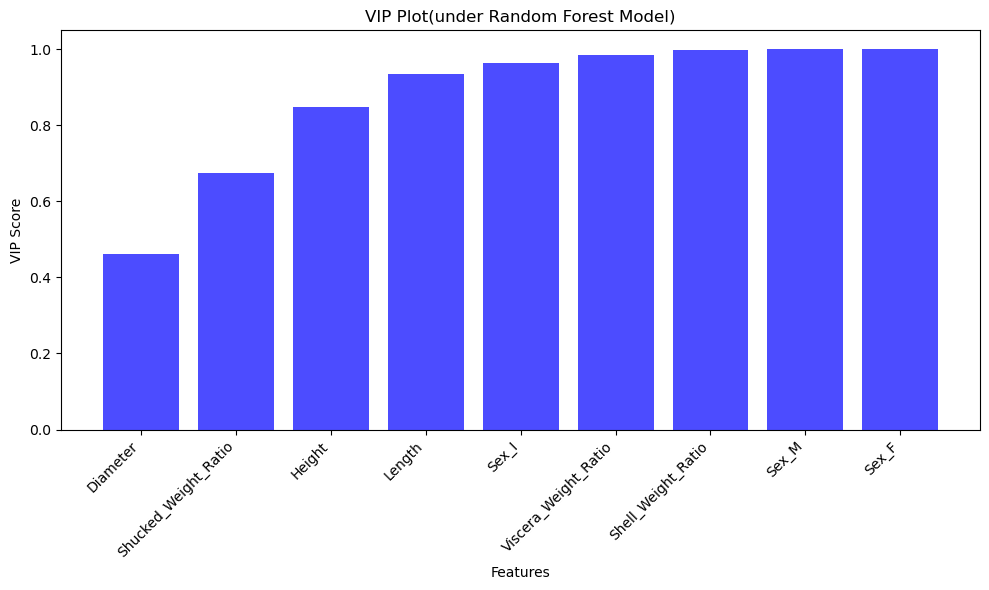

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Train the RandomForestRegressor model with the best parameters
rf_model_best = RandomForestRegressor(**best_params_rf)
rf_model_best.fit(X_train_scaled, Y_train_log)

# Get feature importances from the model
feature_importances = rf_model_best.feature_importances_

# Get the indices of features sorted by importance
sorted_indices = np.argsort(feature_importances)[::-1]

# Calculate VIP scores
vip_scores = np.cumsum(feature_importances[sorted_indices])

# Plot VIP scores
import matplotlib.pyplot as plt

# Define the feature names corresponding to the indices
feature_names = ['Length', 'Diameter', 'Height', 'Shucked_Weight_Ratio', 'Viscera_Weight_Ratio', 'Shell_Weight_Ratio', 'Sex_F', 'Sex_I', 'Sex_M']

plt.figure(figsize=(10, 6))
plt.bar(range(len(vip_scores)), vip_scores, color='blue', alpha=0.7)
plt.xlabel('Features')
plt.ylabel('VIP Score')
plt.title('VIP Plot(under Random Forest Model)')

# Set the feature names as x-axis labels
plt.xticks(range(len(vip_scores)), [feature_names[i] for i in sorted_indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [21]:
# Train the RandomForestRegressor model with the best parameters
rf_model_best = RandomForestRegressor(**best_params_rf)
rf_model_best.fit(X_train_scaled, Y_train_log)
feature_names = ['Length', 'Diameter', 'Height', 'Shucked_Weight_Ratio', 
                 'Viscera_Weight_Ratio', 'Shell_Weight_Ratio', 'Sex_F', 'Sex_I', 'Sex_M']

# Get feature importances from the model
feature_importances = rf_model_best.feature_importances_
# Combine feature names with their respective importances
feature_importances_dict = dict(zip(feature_names, feature_importances))

# Print feature importances
for feature, importance in feature_importances_dict.items():
    print(f"Feature: {feature}, Importance: {importance}")

Feature: Length, Importance: 0.08884896940867781
Feature: Diameter, Importance: 0.46165215692163153
Feature: Height, Importance: 0.1711938800184933
Feature: Shucked_Weight_Ratio, Importance: 0.21436166470114051
Feature: Viscera_Weight_Ratio, Importance: 0.022180949944146492
Feature: Shell_Weight_Ratio, Importance: 0.014107838981982878
Feature: Sex_F, Importance: 0.00024703706254239235
Feature: Sex_I, Importance: 0.027143646227794135
Feature: Sex_M, Importance: 0.0002638567335909754


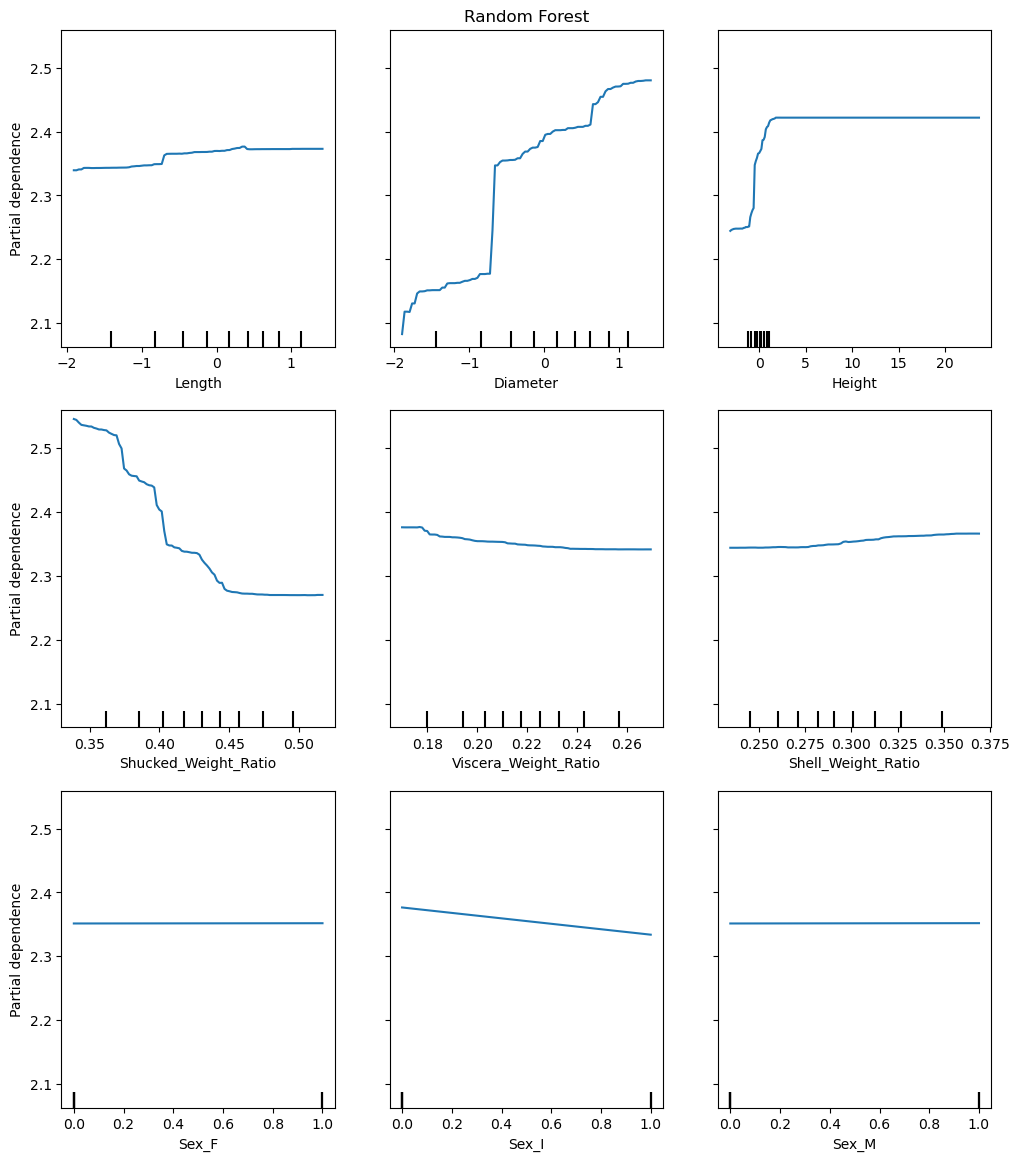

In [29]:
#Partial Dependence Plot for Random Forest Model(Best Model)
from sklearn.inspection import PartialDependenceDisplay
features=[0,1,2,3,4,5,6,7,8]
fig,ax=plt.subplots(figsize=(12,14))
ax.set_title("Random Forest")
PartialDependenceDisplay.from_estimator(rf_model_best,X_train_scaled,
                                        features,target=Y_train_log,ax=ax,feature_names=feature_names)